In [1]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA



In [2]:
#Dataset yang digunakan
kdd_train = pd.read_csv('kdd_train.csv')

# Mengganti label menjadi label 'attacking' untuk setiap bentuk serangan
types = kdd_train["labels"].unique()
types = types[1:]
kdd_train["labels"].replace(to_replace=types, value="attacking", inplace=True)


# mengubah tipe pada kolom "categorical" menjadi string
cols = ['protocol_type', 'service', 'flag', 'labels']
for col in cols:
    kdd_train[col] = kdd_train[col].astype(str)

# Encoding
label_encoders = {}
for col in cols:
    le = LabelEncoder()
    kdd_train[col] = le.fit_transform(kdd_train[col])
    label_encoders[col] = le
    
# Separate features and target variables
X = kdd_train.drop(columns=['labels'])
y = kdd_train['labels']
# X_test = kdd_test.drop(columns=['labels'])
# y_test = kdd_test['labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm the distribution of classes
print("Class Distribution in y_train:")
print(y_train.value_counts())
print("\nClass Distribution in y_test:")
print(y_test.value_counts())



Class Distribution in y_train:
labels
1    53921
0    46857
Name: count, dtype: int64

Class Distribution in y_test:
labels
1    13422
0    11773
Name: count, dtype: int64


In [3]:

# memastikan bahwa label: 0 digunakan untuk label 'normal', dan 1 untuk 'attacking'
y_train = np.where(y_train == 1, 1, 0) 
y_test = np.where(y_test == 1, 1, 0)  


# Select top N features based on Information Gain
from sklearn.feature_selection import mutual_info_classif

info_gain = mutual_info_classif(X_train, y_train, discrete_features='auto')


# Create a DataFrame for feature ranking
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})

# Calculate the mean and standard deviation of information gain
mean_info_gain = np.mean(info_gain)

# Calculate the standard deviation using the provided formula
n = len(info_gain)
sum_xi2 = np.sum(info_gain**2)
sum_xi = np.sum(info_gain)
std_info_gain = np.sqrt((n * sum_xi2 - sum_xi**2) / (n * (n - 1)))

# Set the threshold (e.g., mean + 1 standard deviation)
# threshold = mean_info_gain + std_info_gain
threshold = std_info_gain
threshold

# Select features that meet the threshold criteria
selected_features = feature_ranking[feature_ranking['Information Gain'] > threshold]['Feature']

# Create a new dataset with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


print(f'Selected features based on threshold {threshold} and mean is {mean_info_gain}:')
print(selected_features)


array(['src_bytes', 'service', 'dst_bytes', 'flag', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'logged_in', 'dst_host_serror_rate', 'dst_host_diff_srv_rate',
       'dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate',
       'count', 'dst_host_srv_diff_host_rate', 'dst_host_count',
       'dst_host_same_src_port_rate', 'srv_diff_host_rate', 'srv_count'],
      dtype=object)

In [4]:
# Standardization 
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)






In [15]:

# Inisialisasi model RF dengan parameter terbaik dan class weight balanced
best_params = {
    'bootstrap': False,
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 413,
    'class_weight': 'balanced',
    'random_state': 42
}

rf_model = RandomForestClassifier(**best_params)

# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_selected, y_train, cv=cv, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}, Standard Deviation: {np.std(cv_scores):.4f}')

# Membuat prediksi Cross-validation
y_pred_cv = cross_val_predict(rf_model, X_train_selected, y_train, cv=cv)

# Evaluasi model pada test set
rf_model.fit(X_train_selected, y_train)
y_pred = rf_model.predict(X_test_selected)

# Evaluasi
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attacking'], yticklabels=['Normal', 'Attacking'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('cfbinary.png')
plt.show()


# Save the trained model to a .pkl file
with open('ids_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

print("Model saved as ids_model.pkl")

KeyboardInterrupt: 

In [6]:

# Save the trained model to a .pkl file
with open('ids_binary_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

print("Model saved as ids_model.pkl")

with open('binary_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
    
with open('binary_le.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)


Model saved as ids_model.pkl


In [7]:

# Step 1: Load the saved model
with open('ids_binary_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Step 2: Prepare your actual data (example, replace with your actual data preparation)
# Assuming X_test_actual is your actual data in the format the model expects
# Example: X_test_actual = pd.read_csv('your_new_data.csv')

# Replace this with your actual data preparation
X_test_actual = pd.read_csv('testnormalnoprepros.csv')

# # Define the class mapping
# class_mapping = {
#     'normal': 'normal',
#     'neptune': 'attacking',
#     'back': 'attacking',
#     'teardrop': 'attacking',
#     'pod': 'attacking',
#     'smurf': 'attacking',
#     'satan': 'attacking',
#     'ipsweep': 'attacking',
#     'portsweep': 'attacking',
#     'nmap': 'attacking',
#     'guess_passwd': 'attacking',
#     'warezclient': 'attacking',
#     'ftp_write': 'attacking',
#     'imap': 'attacking',
#     'phf': 'attacking',
#     'spy': 'attacking',
#     'buffer_overflow': 'attacking',
#     'rootkit': 'attacking',
#     'loadmodule': 'attacking',
#     'perl': 'attacking'
# }

# # Apply the mapping to 'labels' column in X_test_actual
# X_test_actual['labels'] = X_test_actual['labels'].map(class_mapping)

# # Check the class distribution after mapping
# class_counts = X_test_actual['labels'].value_counts()
# print("Class Distribution:")
# print(class_counts)

# Convert categorical columns to string type
cols = ['protocol_type', 'service', 'flag']
for col in cols:
    X_test_actual[col] = X_test_actual[col].astype(str)

# Encode categorical columns using label encoders trained on combined_data
for col in cols:
    le = label_encoders[col]  # Reuse the label encoder from training
    X_test_actual[col] = le.transform(X_test_actual[col])

# Select top features and transform using scaler and PCA (assuming you've already defined these)
top_features = ['src_bytes', 'service', 'dst_bytes', 'flag', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'logged_in', 'dst_host_serror_rate', 'dst_host_diff_srv_rate',
       'dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate',
       'count', 'dst_host_srv_diff_host_rate', 'dst_host_count',
       'dst_host_same_src_port_rate', 'srv_diff_host_rate', 'srv_count']

X_test_selected = X_test_actual[top_features]
X_test_selected = scaler.transform(X_test_selected)
# X_test_selected = pca.transform(X_test_selected)

# Step 3: Make predictions
predictions = model.predict(X_test_selected)

# Display predictions
print("Predictions:", predictions)


Predictions: [0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]


In [ ]:
new_data_selected = pd.read_csv('/kaggle/input/nsl-kdd/kdd_test.csv')

types = new_data_selected["labels"].unique()
types = types[1:]
new_data_selected["labels"].replace(to_replace=types, value="attacking", inplace=True)
# Mengubah tipe pada kolom "categorical" menjadi string
cols = ['protocol_type', 'service', 'flag', 'labels']
for col in cols:
        new_data_selected[col] = new_data_selected[col].astype(str)

# Encoding
label_encoders = {}
for col in cols:
        le = LabelEncoder()
        new_data_selected[col] = le.fit_transform(new_data_selected[col])
        label_encoders[col] = le
# Make predictions using the trained model
y_true_new = new_data_selected['labels']
new_data_selected.drop("labels", axis=1, inplace=True)
y_pred_new = rf_model.predict(new_data_selected)


# If you have the true labels in the new data, you can evaluate the model:
print("Accuracy on New Data:", accuracy_score(y_true_new, y_pred_new))
print("Confusion Matrix:\n", confusion_matrix(y_true_new, y_pred_new))
print("Classification Report:\n", classification_report(y_true_new, y_pred_new, zero_division=1))

    # Optionally, you can visualize the confusion matrix
cm_new = confusion_matrix(y_true_new, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attacking'], yticklabels=['Normal', 'Attacking'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for New Data')
plt.savefig('cfbinary_new.png')
plt.show()


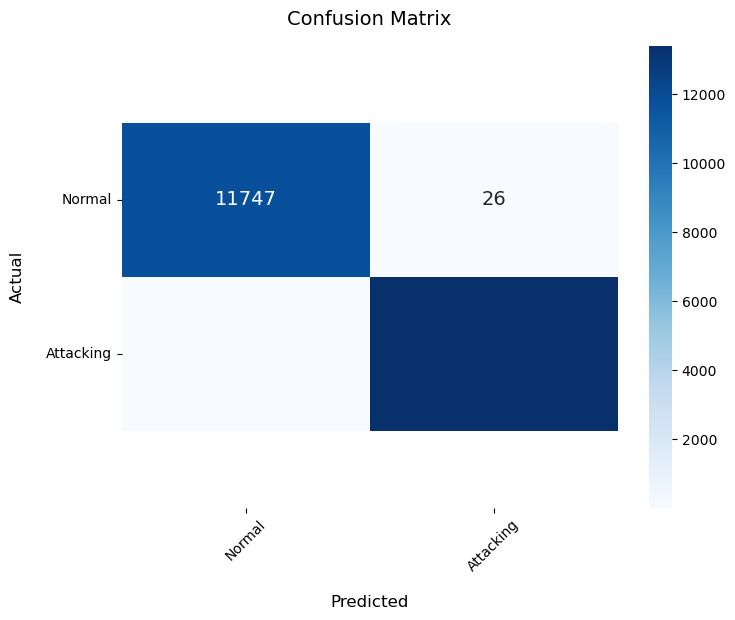

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))  # Maintain the original figure size
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=['Normal', 'Attacking'], yticklabels=['Normal', 'Attacking'], 
                 annot_kws={"size": 14}, cbar=True)  # Adjust annotation font size

# Adjustments to make sure the labels and annotations are visible
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted', fontsize=12, labelpad=15)
plt.ylabel('Actual', fontsize=12, labelpad=15)
plt.title('Confusion Matrix', fontsize=14, pad=15)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.savefig('cfbinary_fixed.png', bbox_inches='tight', pad_inches=0.5)
plt.show()
